In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
data = pd.read_csv("international-airline-passengers.csv")
data.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [3]:
data.columns = ["dt", "Passengers"]

In [4]:
data.head()

,dt,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [5]:
data.shape

(145, 2)

In [6]:
data = data.iloc[:-1]

In [7]:
data["dt"] = data["dt"].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m'))

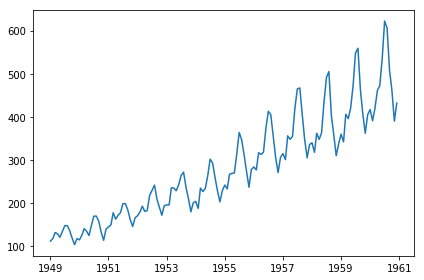

In [8]:
plt.plot(data["dt"], data["Passengers"])
plt.tight_layout()

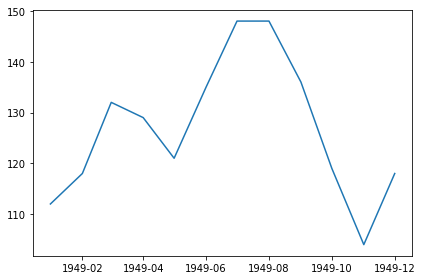

In [9]:
plt.plot(data["dt"].iloc[:12], data["Passengers"].iloc[:12])
plt.tight_layout()

In [10]:
data[["dt"]].groupby(data["dt"].dt.year).count()

,dt
dt,
1949,12
1950,12
1951,12
1952,12
1953,12
1954,12
1955,12
1956,12
1957,12


In [11]:
def create_xy(df, target_column):
    return df.drop(target_column, axis=1), df[target_column]

def split_data(df, target_column):
    X_train, y_train = create_xy(df.query("dt < 1959"), target_column)
    X_dev, y_dev = create_xy(df.query("dt >= 1959 and dt < 1960"), target_column)
    X_test, y_test = create_xy(df.query("dt >= 1960"), target_column)
    return X_train, y_train, X_dev, y_dev, X_test, y_test

In [12]:
X_train, y_train, X_dev, y_dev, X_test, y_test = split_data(data, "Passengers")

In [13]:
X_train[["dt"]].groupby(X_train["dt"].dt.year).count()

,dt
dt,
1949,12
1950,12
1951,12
1952,12
1953,12
1954,12
1955,12
1956,12
1957,12


In [14]:
y_dev_hat = [y_train[X_train["dt"].dt.year == 1958].mean()]*12

In [15]:
data.query("dt >= 1959 and dt < 1960")

,dt,Passengers
120,1959-01-01,360.0
121,1959-02-01,342.0
122,1959-03-01,406.0
123,1959-04-01,396.0
124,1959-05-01,420.0
125,1959-06-01,472.0
126,1959-07-01,548.0
127,1959-08-01,559.0
128,1959-09-01,463.0
129,1959-10-01,407.0


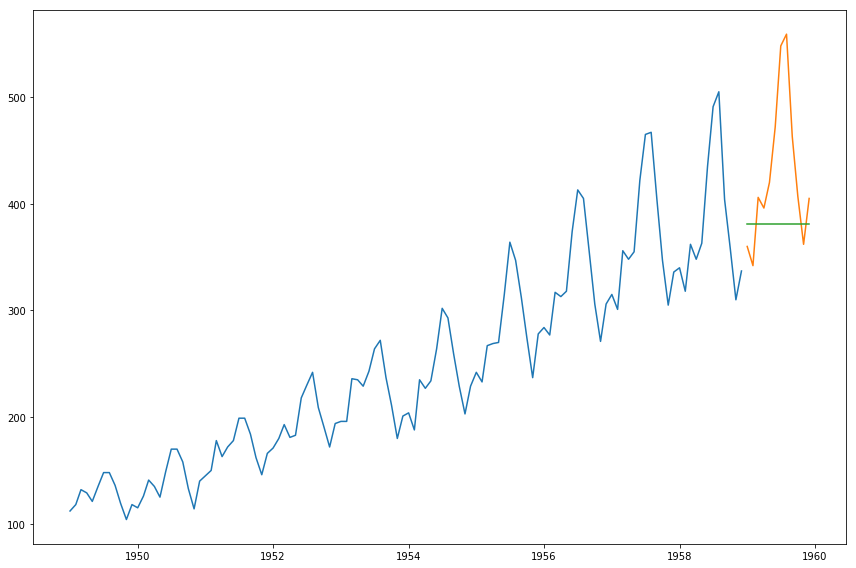

In [16]:
figure = plt.subplots(1,1, figsize=(12,8))
plt.plot(X_train, y_train)
plt.plot(X_dev, y_dev)
plt.plot(X_dev, y_dev_hat)
plt.tight_layout()

In [17]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

81.91662427940578

In [18]:
from pandas import Series
from statsmodels.tsa.seasonal import seasonal_decompose

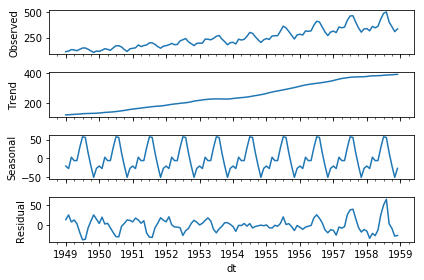

In [19]:
train = pd.DataFrame()
train["dt"] = X_train["dt"]
train["y"] = y_train
series = train.set_index("dt")
result = seasonal_decompose(series, model="additive", extrapolate_trend="freq")
result.plot()
plt.show()

In [20]:
(result.trend.index[14]-result.trend.index[0]).days

424

In [21]:
result.trend["Days"] = result.trend.apply(lambda x: (x.index - result.trend.index[0]).days)
result.trend.head()

,y,Days
dt,,
1949-01-01,118.588481,0
1949-02-01,119.734169,31
1949-03-01,120.879856,59
1949-04-01,122.025544,90
1949-05-01,123.171232,120


In [23]:
X_dev_days = X_dev.copy()
X_dev_days["Days"] = X_dev_days["dt"].apply(lambda x: (x - result.trend.index[0]).days)
#X_dev_days["dt"].apply(lambda x: print(x, X_dev_days["dt"].min()))
X_dev_days.head()

,dt,Days
120,1959-01-01,3652
121,1959-02-01,3683
122,1959-03-01,3711
123,1959-04-01,3742
124,1959-05-01,3772


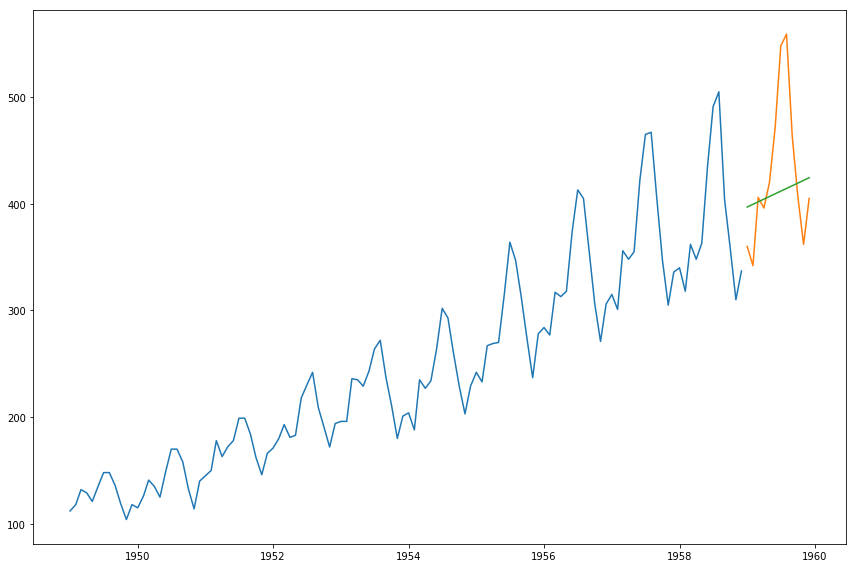

In [24]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(result.trend[["Days"]], result.trend["y"])

y_dev_hat = reg.predict(X_dev_days[["Days"]])
y_dev_trend = y_dev_hat

figure = plt.subplots(1,1, figsize=(12,8))
plt.plot(X_train, y_train)
plt.plot(X_dev, y_dev)
plt.plot(X_dev, y_dev_hat)
plt.tight_layout()

In [25]:
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

67.42825573174939

In [26]:
y_dev_hat

array([396.96913629, 399.5152001 , 401.81487064, 404.36093445,
       406.82486717, 409.37093098, 411.8348637 , 414.38092752,
       416.92699133, 419.39092405, 421.93698786, 424.40092058])

In [27]:
np.array(np.array([0]*12) + result.seasonal["y"][0:12])

array([-20.74875194, -27.47998737,   2.8012772 ,  -6.32995824,
        -6.10286033,  28.31173757,  57.28793221,  55.58571775,
        14.67516997, -20.01454448, -50.95425894, -27.03147339])

In [28]:
y_dev_hat = np.array(y_dev_hat + result.seasonal["y"][0:12])
y_dev_hat

array([376.22038434, 372.03521272, 404.61614783, 398.03097621,
       400.72200684, 437.68266855, 469.12279591, 469.96664527,
       431.6021613 , 399.37637957, 370.98272893, 397.3694472 ])

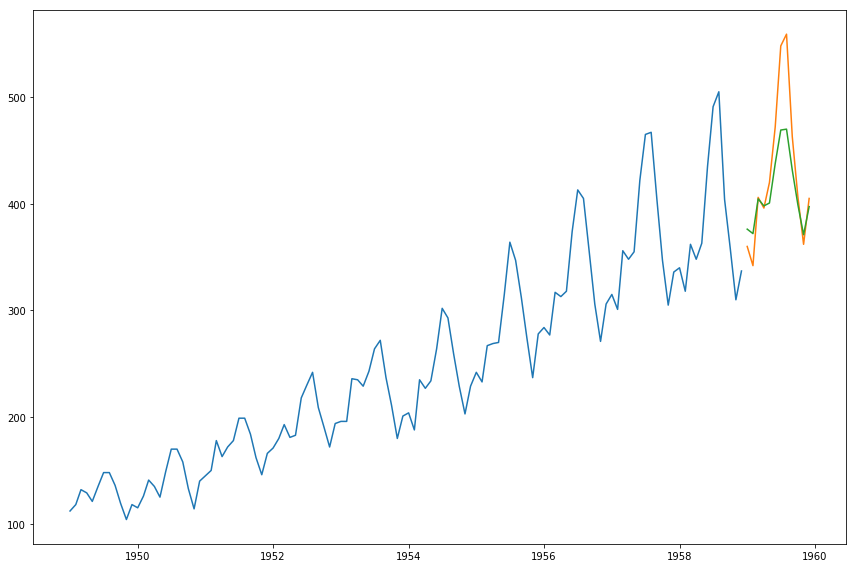

In [29]:
figure = plt.subplots(1,1, figsize=(12,8))
plt.plot(X_train, y_train)
plt.plot(X_dev, y_dev)
plt.plot(X_dev, y_dev_hat)
plt.tight_layout()

In [30]:
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

38.785720352287036

In [31]:
y_train[0:12]

0     112.0
1     118.0
2     132.0
3     129.0
4     121.0
5     135.0
6     148.0
7     148.0
8     136.0
9     119.0
10    104.0
11    118.0
Name: Passengers, dtype: float64

In [32]:
std_df = pd.DataFrame(columns=["Season", "Std"])

for i in range(0, 10*12, 12):
    std_df = std_df.append({"Season": i/12, 
                            "Std": np.std(y_train[i:(i+12)])/np.std(result.seasonal["y"][0:12])}, 
                           ignore_index=True)

std_df.head()

,Season,Std
0,0.0,0.408857
1,1.0,0.568306
2,2.0,0.549456
3,3.0,0.684392
4,4.0,0.848306


In [33]:
reg = LinearRegression()
reg.fit(std_df[["Season"]], std_df["Std"])

y_dev_std = reg.predict(10.0)

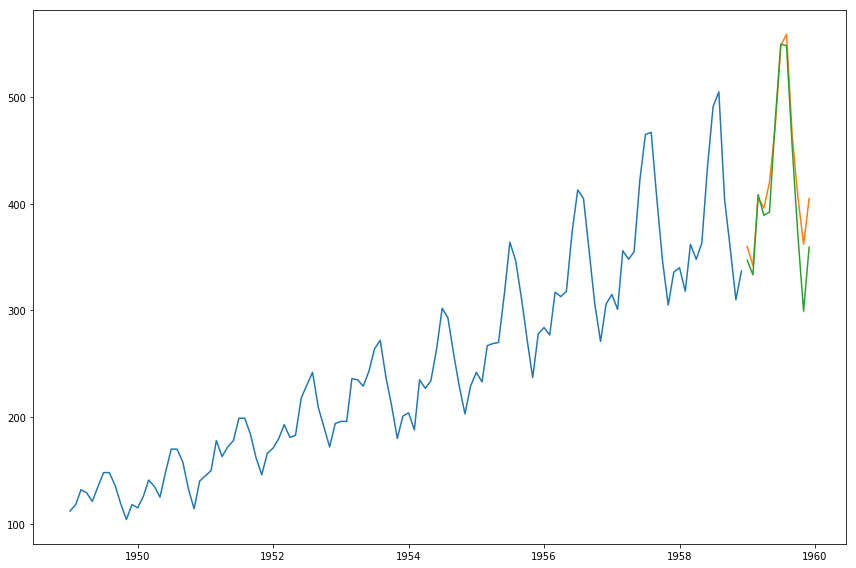

In [34]:
y_dev_hat = np.array(y_dev_trend + result.seasonal["y"][0:12])
y_dev_hat = y_dev_hat + (y_dev_hat - y_dev_trend) * np.sqrt(y_dev_std)

figure = plt.subplots(1,1, figsize=(12,8))
plt.plot(X_train, y_train)
plt.plot(X_dev, y_dev)
plt.plot(X_dev, y_dev_hat)
plt.tight_layout()

In [35]:
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

26.812341677749846

In [36]:
np.std(result.seasonal["y"][0:12]), np.std(y_train[(6*12):(6*12+12)])

(32.1286919840472, 40.34641661081357)

0.96314400937308

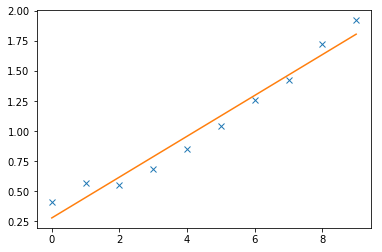

In [37]:
from sklearn.metrics import r2_score
plt.plot(std_df["Season"], std_df["Std"], 'x')
plt.plot(std_df["Season"], reg.predict(std_df[["Season"]]))
r2_score(std_df[["Std"]], reg.predict(std_df[["Season"]]))

In [38]:
np.std(y_dev_trend + result.seasonal["y"][0:12])

32.85696586426131

In [39]:
pd.DataFrame(y_train).head()

,Passengers
0,112.0
1,118.0
2,132.0
3,129.0
4,121.0


In [52]:
def create_lags(Xy, n_lags):
    Xy_with_lags = pd.DataFrame(Xy)
    for i in range(1, n_lags+1):
        Xy_with_lags['pass-'+str(i)] = Xy_with_lags[['Passengers']].shift(i)
    return Xy_with_lags.iloc[n_lags:]

In [67]:
data_lags = create_lags(data, 12)
data_lags.head()

,dt,Passengers,pass-1,pass-2,pass-3,pass-4,pass-5,pass-6,pass-7,pass-8,pass-9,pass-10,pass-11,pass-12
12,1950-01-01,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0
13,1950-02-01,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0
14,1950-03-01,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0
15,1950-04-01,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0
16,1950-05-01,125.0,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0


In [68]:
X_train_lags, y_train_lags, X_dev_lags, y_dev_lags, X_test_lags, y_test_lags = split_data(data_lags, "Passengers")

In [69]:
X_train_lags.head()

,dt,pass-1,pass-2,pass-3,pass-4,pass-5,pass-6,pass-7,pass-8,pass-9,pass-10,pass-11,pass-12
12,1950-01-01,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0
13,1950-02-01,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0
14,1950-03-01,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0
15,1950-04-01,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0
16,1950-05-01,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0


In [70]:
def recurrent_prediction(y_train, n_steps, reg):
    x_dev = list(y_train[-1:-(n_steps +1):-1])
    y_dev_hat = []
    for i in range(n_steps):
        y_hat = reg.predict([x_dev])[0]
        y_dev_hat.append(y_hat)
        x_dev.pop(-1)
        x_dev = [y_hat] + x_dev
    return y_dev_hat

In [71]:
from sklearn.neighbors import KNeighborsRegressor

for i in range(1,10):
    reg_kn = KNeighborsRegressor(n_neighbors=i)
    reg_kn.fit(X_train_lags.drop("dt", axis=1), y_train_lags)
    y_dev_hat = recurrent_prediction(y_train_lags, 12, reg_kn)
    print("Neighbors: ", i, "RSME: ", np.sqrt(mean_squared_error(y_dev_lags, y_dev_hat)))

Neighbors:  1 RSME:  49.25444142409901
Neighbors:  2 RSME:  55.49136569473369
Neighbors:  3 RSME:  49.20779823775299
Neighbors:  4 RSME:  50.448096264048125
Neighbors:  5 RSME:  57.255101664975385
Neighbors:  6 RSME:  59.30504163191325
Neighbors:  7 RSME:  61.15484417432847
Neighbors:  8 RSME:  59.05525749245363
Neighbors:  9 RSME:  63.41100662595471
